In [1]:
import torch
assert torch.cuda.is_available(), "Cuda isn't available"


In [2]:
import os
print(os.getcwd())

/home/labs/testing/class62/CT-Inpainting


In [3]:
import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import time

from data_loader import CTDataset
from model_vqvae2 import VQVAE
from unet3d.models.pytorch.autoencoder.variational import ConvolutionalAutoEncoder

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
EASY_MODE = False

In [6]:
from datetime import datetime

def get_cur_model_checkpoint_prefix():
    now = datetime.now()
    time_str = now.strftime("%m-%d-%y-%H%M")
    return f"./checkpoints/{time_str}-epoch-"

In [7]:
print(get_cur_model_checkpoint_prefix())

./checkpoints/03-17-23-1150-epoch-


In [8]:
def normalize(vec):
    # print(vec.shape)
    # TODO change if parse batch
    # vec -= vec.min(1, keepdim=True)[0] - 0.01
    # vec /= (vec.max(1, keepdim=True)[0] + 0.01)
    vec -= vec.min() - 0.01
    vec /= (vec.max() + 0.01)
    vec *= 255
    return vec
    

def psnr(im, ref, margin=2):
    """
    Args:
    im (torch.Tensor): Image to be evaluated. 
    Has shape `(num_channels, height, width)`.
    ref (torch.Tensor): reference image. 
    Has shape `(num_channels, height, width)`. 

    Returns:
    psnr (int): psnr value of the images.
    """
    # assume images are tensors float 0-1.
    # im, ref = (im*255).round(), (ref*255).round()
    # rgb2gray = torch.Tensor([65.481, 128.553, 24.966]).to(im.device)[None, :, None, None]
    gray_im = im #torch.sum(im * rgb2gray, dim=1) + 16
    gray_ref = ref # torch.sum(ref * rgb2gray, dim=1) + 16
    clipped_im = normalize(gray_im)
    clipped_ref = normalize(gray_ref).squeeze()
    shaved_im = clipped_im#[margin:-margin, margin:-margin]
    shaved_ref = clipped_ref#[margin:-margin, margin:-margin]    
    return 20 * torch.log10(torch.tensor(255.)) -10.0 * ((shaved_im) - (shaved_ref) + 0.00001).pow(2.0).mean().log10()

In [9]:
#################################################
# PROVIDED: PSNR evaluation method
#################################################
def psnr_orig(im, ref, margin=2):
    """
    Args:
    im (torch.Tensor): Image to be evaluated. 
    Has shape `(num_channels, height, width)`.
    ref (torch.Tensor): reference image. 
    Has shape `(num_channels, height, width)`. 

    Returns:
    psnr (int): psnr value of the images.
    """
    # assume images are tensors float 0-1.
    # im, ref = (im*255).round(), (ref*255).round()
    # rgb2gray = torch.Tensor([65.481, 128.553, 24.966]).to(im.device)[None, :, None, None]
    gray_im = im #torch.sum(im * rgb2gray, dim=1) + 16
    gray_ref = ref # torch.sum(ref * rgb2gray, dim=1) + 16
    clipped_im = torch.clamp(gray_im, 0, 255).squeeze()
    clipped_ref = torch.clamp(gray_ref, 0, 255).squeeze()
    shaved_im = clipped_im#[margin:-margin, margin:-margin]
    shaved_ref = clipped_ref#[margin:-margin, margin:-margin]    
    return 20 * torch.log10(torch.tensor(255.)) -10.0 * ((shaved_im) - (shaved_ref)).pow(2.0).mean().log10()

In [10]:
def train_epoch(model, optimizer, train_criterion, data_loader, loss_history, device):
    total_samples = len(data_loader.dataset)
    model.train()
    total_loss = 0
    for i, (scan, mask, masked) in enumerate(data_loader):
        target = scan
        mask = mask.to(device)
        masked = masked.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        masked = masked[None, :]
        masked = masked.transpose(0, 1)
        # output, diff = model(masked)
        output = model(masked)
        if False: #EASY_MODE:
            # TODO remove clamp?
            output -= output.min(1, keepdim=True)[0] - 0.01
            output /= output.max(1, keepdim=True)[0] + 0.01
        output = output.squeeze()
        # TODO consider remove this squeeze
        target = target.squeeze()
        
        predicted_mask = torch.masked_select(output, mask)
        target_mask = torch.masked_select(target, mask)
        loss = train_criterion(predicted_mask, target_mask)
        # TODO reset to mask loss?
        # loss = train_criterion(output, target)
        
        # print(f"loss: {loss.cpu()}")
        # loss.sum()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(scan)) + '/' + '{:5}'.format(total_samples) +
                ' (' + '{:3.0f}'.format(100 * i / total_samples) + '%)]  Loss: ' +
                '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())
    
    return total_loss/total_samples

In [ ]:
def evaluate(model, data_loader, criterion, loss_history, device):
    model.eval()
  
    total_psnr = 0
    total_loss = 0
    total_samples = len(data_loader.dataset)

    with torch.no_grad():
        for i, (scan, mask, masked) in enumerate(data_loader):
            target = scan
            mask = mask.to(device)
            masked = masked.to(device)
            target = target.to(device)

            masked = masked[None, :]
            masked = masked.transpose(0, 1)
            # output, diff = model(masked)
            output = model(masked)
            if False: #EASY_MODE:
                # TODO remove\ clamp?
                output -= output.min(1, keepdim=True)[0] - 0.01
                output /= output.max(1, keepdim=True)[0] + 0.01
                # output = torch.clamp(masked, 0.01, 0.99)
            output = output.squeeze()
            # TODO consider remove this squeeze
            target = target.squeeze()
            
            
            predicted_mask = torch.masked_select(output, mask)
            target_mask = torch.masked_select(target, mask)
            loss = criterion(predicted_mask, target_mask)
            # TODO return full loss
            # loss = criterion(output, target)
            

            cur_psnr = psnr(predicted_mask, target_mask)
            
            total_loss += loss.item()
            total_psnr += cur_psnr

    avg_loss = total_loss / total_samples
    avg_psnr = total_psnr / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
            '  Average test PSNR:' + '{}'.format(avg_psnr)+'\n')
    return avg_loss, avg_psnr


In [ ]:
def train(lr=1e-2, n_epochs=10, limit_dataset=None, batch_size_train=10, batch_size_test=10, lr_decay=1, lr_step=10, transforms_per_scan=10, load_model=False):
    device = torch.device('cuda')
    start_time = time.time()
    
    tb_writer = SummaryWriter()

    model_checkpoint_prefix = get_cur_model_checkpoint_prefix()
    
    if EASY_MODE:
        mask_dims = (16, 16)
    else:
        mask_dims = (64, 64)
    # Load data
    DATASET_DIR = "COVID-CTset"    
    
    train_set = CTDataset(DATASET_DIR, limit_dataset=limit_dataset, num_masked_slices=2, padding_slices=3, mask_dims=mask_dims, transforms_per_scan=transforms_per_scan)
    # train_set = CTDataset(DATASET_DIR, limit_dataset=limit_dataset, num_masked_slices=2, padding_slices=3)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=2)

    test_set = train_set
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=False, num_workers=2)

    # Initialize model
    # model = VQVAE(in_channel=1).to(device)
    # Relevant model params: base_width=64, encoder_blocks=[1,2,2,4,4]
    model =  ConvolutionalAutoEncoder(decoder_mirrors_encoder=True).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_decay)
    
    if load_model:
        prev_model_path = r"./checkpoints/03-17-23-0125-epoch-300"
        checkpoint = torch.load(prev_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
    
    if EASY_MODE:
        # criterion = torch.nn.BCELoss()
        # criterion = torch.nn.L1Loss()
        criterion = torch.nn.MSELoss()
        
    else:
        early_criterion = torch.nn.MSELoss()
#         early_criterion = torch.nn.L1Loss()
#         late_criterion = torch.nn.MSELoss()
        criterion = torch.nn.L1Loss()
            
    
    
    # Train model
    train_loss_history, test_loss_history = [], []
    for epoch in range(1, n_epochs + 1):
        curr_start_time = time.time()
        if not EASY_MODE:
            if epoch < 50:
                criterion = early_criterion
            if epoch > 50:
                criterion = late_criterion
        train_loss = train_epoch(model, optimizer, criterion, train_loader, train_loss_history, device)
        tb_writer.add_scalar("Loss/train", train_loss, epoch)
        tb_writer.add_scalar("lr", scheduler.optimizer.param_groups[0]['lr'], epoch)
        
        scheduler.step()
        if epoch % 10 == 0:
            eval_loss, eval_psnr = evaluate(model, test_loader, criterion, test_loss_history, device)
            print('Epoch:', epoch)
            print(f'Epoch {epoch} execution time:', '{:5.2f}'.format((time.time() - curr_start_time) / 60), 'minutes\n')
            tb_writer.add_scalar("Loss/val", eval_loss, epoch)
            tb_writer.add_scalar("PSNR/val", eval_psnr, epoch)
            if epoch % 50 == 0:
                torch.save({'epoch': epoch,
                            'loss': train_loss,
                            'val_loss': eval_loss,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict()},
                            model_checkpoint_prefix + str(epoch))


    print('Execution time:', '{:5.2f}'.format((time.time() - start_time) / 60), 'minutes')
    return model



In [ ]:
# model = train(n_epochs=10000, limit_dataset=1, batch_size_train=1, batch_size_test=1, lr=0.01, lr_step=100, lr_decay=0.5)
# model = train(n_epochs=100, limit_dataset=None, batch_size_train=2, batch_size_test=2, lr=0.001, lr_step=30, lr_decay=0.1)

In [ ]:
model_100_1000 = train(n_epochs=1000, limit_dataset=100, batch_size_train=5, batch_size_test=5, lr=0.001, lr_step=50, lr_decay=0.5, transforms_per_scan=1)

In [ ]:
model_10_1000 = train(n_epochs=1000, limit_dataset=10, batch_size_train=4, batch_size_test=4, lr=0.001, lr_step=50, lr_decay=0.5, transforms_per_scan=1)

In [16]:
model_none = train(n_epochs=1, limit_dataset=3, batch_size_train=3, batch_size_test=3, lr=0.001, lr_step=50, lr_decay=0.5, transforms_per_scan=1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB (GPU 0; 31.75 GiB total capacity; 29.50 GiB already allocated; 35.75 MiB free; 30.54 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# model = train(n_epochs=10000, limit_dataset=1, batch_size_train=1, batch_size_test=1, lr=0.01, lr_step=100, lr_decay=0.5)
model3 = train(n_epochs=500, limit_dataset=None, batch_size_train=5, batch_size_test=5, lr=0.001, lr_step=50, lr_decay=0.5, transforms_per_scan=1)

In [10]:
# model = train(n_epochs=10000, limit_dataset=1, batch_size_train=1, batch_size_test=1, lr=0.01, lr_step=100, lr_decay=0.5)
model2 = train(n_epochs=150, limit_dataset=1, batch_size_train=5, batch_size_test=2, lr=0.001, lr_step=50, lr_decay=0.5)

Encoder 0: 1 32
Encoder 1: 32 64
Encoder 2: 64 128
Encoder 3: 128 256
[    0/   10 (  0%)]  Loss: 441.8690
[    0/   10 (  0%)]  Loss: 141.4611
[    0/   10 (  0%)]  Loss: 261.7535
[    0/   10 (  0%)]  Loss: 354.1408
[    0/   10 (  0%)]  Loss: 251.8744
[    0/   10 (  0%)]  Loss: 178.0492
[    0/   10 (  0%)]  Loss: 199.3390
[    0/   10 (  0%)]  Loss: 198.6155
[    0/   10 (  0%)]  Loss: 192.5952
[    0/   10 (  0%)]  Loss: 189.6219

Average test loss: 82.4257  Average test PSNR:5.199817657470703

Epoch: 10
Epoch 10 execution time:  0.41 minutes

[    0/   10 (  0%)]  Loss: 166.1799
[    0/   10 (  0%)]  Loss: 182.6690
[    0/   10 (  0%)]  Loss: 167.3730
[    0/   10 (  0%)]  Loss: 156.7963
[    0/   10 (  0%)]  Loss: 157.6315
[    0/   10 (  0%)]  Loss: 168.1282
[    0/   10 (  0%)]  Loss: 171.7680
[    0/   10 (  0%)]  Loss: 135.0869
[    0/   10 (  0%)]  Loss: 120.7612
[    0/   10 (  0%)]  Loss: 139.9652

Average test loss: 61.2981  Average test PSNR:7.868302822113037

Epoch: 2

In [11]:
# Mar02_00-47-14_hgn02.wexac.weizmann.ac.il
# model = train(n_epochs=10000, limit_dataset=1, batch_size_train=1, batch_size_test=1, lr=0.01, lr_step=100, lr_decay=0.5)
model3 = train(n_epochs=500, limit_dataset=1, batch_size_train=5, batch_size_test=2, lr=0.001, lr_step=100, lr_decay=0.5)

Encoder 0: 1 32
Encoder 1: 32 64
Encoder 2: 64 128
Encoder 3: 128 256
[    0/   10 (  0%)]  Loss: 441.1411
[    0/   10 (  0%)]  Loss: 216.4379
[    0/   10 (  0%)]  Loss: 334.5015
[    0/   10 (  0%)]  Loss: 175.9998
[    0/   10 (  0%)]  Loss: 162.9393
[    0/   10 (  0%)]  Loss: 201.5105
[    0/   10 (  0%)]  Loss: 134.8366
[    0/   10 (  0%)]  Loss: 159.7195
[    0/   10 (  0%)]  Loss: 122.3824
[    0/   10 (  0%)]  Loss: 160.8002

Average test loss: 74.8869  Average test PSNR:7.693093776702881

Epoch: 10
Epoch 10 execution time:  0.25 minutes

[    0/   10 (  0%)]  Loss: 157.0838
[    0/   10 (  0%)]  Loss: 120.9159
[    0/   10 (  0%)]  Loss: 164.6349
[    0/   10 (  0%)]  Loss: 124.0043
[    0/   10 (  0%)]  Loss: 140.9819
[    0/   10 (  0%)]  Loss: 119.5129
[    0/   10 (  0%)]  Loss: 127.2414
[    0/   10 (  0%)]  Loss: 117.8837
[    0/   10 (  0%)]  Loss: 109.0876
[    0/   10 (  0%)]  Loss: 125.9388

Average test loss: 54.3821  Average test PSNR:7.455120086669922

Epoch: 2

In [12]:
# Mar02_02-31-24_hgn02.wexac.weizmann.ac.il
# model = train(n_epochs=10000, limit_dataset=1, batch_size_train=1, batch_size_test=1, lr=0.01, lr_step=100, lr_decay=0.5)
model4 = train(n_epochs=1000, limit_dataset=1, batch_size_train=5, batch_size_test=2, lr=0.001, lr_step=200, lr_decay=0.5)

Encoder 0: 1 32
Encoder 1: 32 64
Encoder 2: 64 128
Encoder 3: 128 256
[    0/   10 (  0%)]  Loss: 439.6493
[    0/   10 (  0%)]  Loss: 514.8099
[    0/   10 (  0%)]  Loss: 271.9730
[    0/   10 (  0%)]  Loss: 159.3485
[    0/   10 (  0%)]  Loss: 210.1008
[    0/   10 (  0%)]  Loss: 162.6179
[    0/   10 (  0%)]  Loss: 140.3656
[    0/   10 (  0%)]  Loss: 145.8681
[    0/   10 (  0%)]  Loss: 133.2991
[    0/   10 (  0%)]  Loss: 136.8720

Average test loss: 65.0705  Average test PSNR:7.432119846343994

Epoch: 10
Epoch 10 execution time:  0.25 minutes

[    0/   10 (  0%)]  Loss: 144.6543
[    0/   10 (  0%)]  Loss: 121.0492
[    0/   10 (  0%)]  Loss: 120.8686
[    0/   10 (  0%)]  Loss: 122.4398
[    0/   10 (  0%)]  Loss: 131.6337
[    0/   10 (  0%)]  Loss: 126.2058
[    0/   10 (  0%)]  Loss: 136.7221
[    0/   10 (  0%)]  Loss: 112.9031
[    0/   10 (  0%)]  Loss: 126.0214
[    0/   10 (  0%)]  Loss: 122.2920

Average test loss: 56.8851  Average test PSNR:7.853710174560547

Epoch: 2

In [14]:
# Mar02_08-36-15_hgn02.wexac.weizmann.ac.il
# model = train(n_epochs=10000, limit_dataset=1, batch_size_train=1, batch_size_test=1, lr=0.01, lr_step=100, lr_decay=0.5)
model5 = train(n_epochs=1000, limit_dataset=5, batch_size_train=5, batch_size_test=2, lr=0.001, lr_step=200, lr_decay=0.5)

Encoder 0: 1 32
Encoder 1: 32 64
Encoder 2: 64 128
Encoder 3: 128 256
[    0/   50 (  0%)]  Loss: 408.6734
[    0/   50 (  0%)]  Loss: 168.2387
[    0/   50 (  0%)]  Loss: 115.1357
[    0/   50 (  0%)]  Loss: 121.5352
[    0/   50 (  0%)]  Loss: 118.0564
[    0/   50 (  0%)]  Loss: 122.2648
[    0/   50 (  0%)]  Loss: 107.4532
[    0/   50 (  0%)]  Loss: 100.9482
[    0/   50 (  0%)]  Loss: 113.1618
[    0/   50 (  0%)]  Loss: 104.7735

Average test loss: 49.6636  Average test PSNR:9.044269561767578

Epoch: 10
Epoch 10 execution time:  1.20 minutes

[    0/   50 (  0%)]  Loss: 98.6832
[    0/   50 (  0%)]  Loss: 105.4285
[    0/   50 (  0%)]  Loss: 105.9462
[    0/   50 (  0%)]  Loss: 105.5016
[    0/   50 (  0%)]  Loss: 105.2072
[    0/   50 (  0%)]  Loss: 99.3143
[    0/   50 (  0%)]  Loss: 95.8282
[    0/   50 (  0%)]  Loss: 101.0533
[    0/   50 (  0%)]  Loss: 92.6463
[    0/   50 (  0%)]  Loss: 82.2498

Average test loss: 42.8800  Average test PSNR:9.898303985595703

Epoch: 20
Epo

In [22]:
# Mar03_01-23-25_hgn02.wexac.weizmann.ac.il
# model = train(n_epochs=10000, limit_dataset=1, batch_size_train=1, batch_size_test=1, lr=0.01, lr_step=100, lr_decay=0.5)
# print(6)
model6 = train(n_epochs=100, limit_dataset=100, batch_size_train=5, batch_size_test=2, lr=0.001, lr_step=50, lr_decay=0.5)

Encoder 0: 1 32
Encoder 1: 32 64
Encoder 2: 64 128
Encoder 3: 128 256
[    0/ 1000 (  0%)]  Loss: 259.7649
[  500/ 1000 ( 10%)]  Loss: 134.4470
[    0/ 1000 (  0%)]  Loss: 121.2618
[  500/ 1000 ( 10%)]  Loss: 107.2187
[    0/ 1000 (  0%)]  Loss: 134.8837
[  500/ 1000 ( 10%)]  Loss: 102.8598
[    0/ 1000 (  0%)]  Loss: 109.6211
[  500/ 1000 ( 10%)]  Loss: 112.6616
[    0/ 1000 (  0%)]  Loss: 97.6909
[  500/ 1000 ( 10%)]  Loss: 110.3178
[    0/ 1000 (  0%)]  Loss: 88.4287
[  500/ 1000 ( 10%)]  Loss: 84.1011
[    0/ 1000 (  0%)]  Loss: 86.2027
[  500/ 1000 ( 10%)]  Loss: 102.7232
[    0/ 1000 (  0%)]  Loss: 107.2868
[  500/ 1000 ( 10%)]  Loss: 58.2732
[    0/ 1000 (  0%)]  Loss: 60.7156
[  500/ 1000 ( 10%)]  Loss: 74.7844
[    0/ 1000 (  0%)]  Loss: 96.3574
[  500/ 1000 ( 10%)]  Loss: 83.3400

Average test loss: 40.3996  Average test PSNR:9.215460777282715

Epoch: 10
Epoch 10 execution time: 23.53 minutes

[    0/ 1000 (  0%)]  Loss: 69.7388
[  500/ 1000 ( 10%)]  Loss: 70.5788
[    0/ 100

In [24]:
# model = train(n_epochs=10000, limit_dataset=1, batch_size_train=1, batch_size_test=1, lr=0.01, lr_step=100, lr_decay=0.5)
model7 = train(n_epochs=1000, limit_dataset=5, batch_size_train=5, batch_size_test=2, lr=0.001, lr_step=200, lr_decay=0.5)

Encoder 0: 1 32
Encoder 1: 32 64
Encoder 2: 64 128
Encoder 3: 128 256
[    0/   50 (  0%)]  Loss: 213284.1719
[    0/   50 (  0%)]  Loss: 47776.7578
[    0/   50 (  0%)]  Loss: 32683.2324
[    0/   50 (  0%)]  Loss: 27164.1934
[    0/   50 (  0%)]  Loss: 30237.0195
[    0/   50 (  0%)]  Loss: 22331.3770
[    0/   50 (  0%)]  Loss: 26579.4121
[    0/   50 (  0%)]  Loss: 22504.6621
[    0/   50 (  0%)]  Loss: 26338.3379
[    0/   50 (  0%)]  Loss: 19414.1758

Average test loss: 9432.7852  Average test PSNR:9.531982421875

Epoch: 10
Epoch 10 execution time:  1.19 minutes

[    0/   50 (  0%)]  Loss: 19463.9062
[    0/   50 (  0%)]  Loss: 21055.6270
[    0/   50 (  0%)]  Loss: 22970.2070
[    0/   50 (  0%)]  Loss: 20225.5918
[    0/   50 (  0%)]  Loss: 14918.6592
[    0/   50 (  0%)]  Loss: 21310.4180
[    0/   50 (  0%)]  Loss: 16115.4316
[    0/   50 (  0%)]  Loss: 15854.9395
[    0/   50 (  0%)]  Loss: 19592.1133
[    0/   50 (  0%)]  Loss: 15852.6660

Average test loss: 8077.4748  Ave

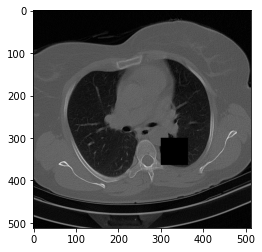

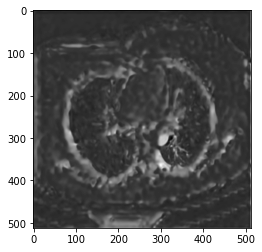

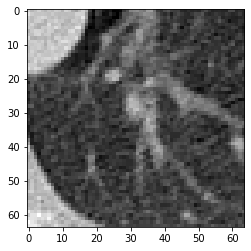

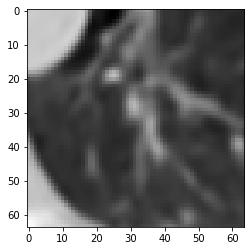

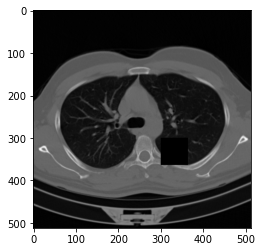

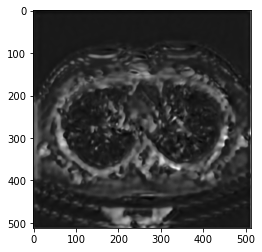

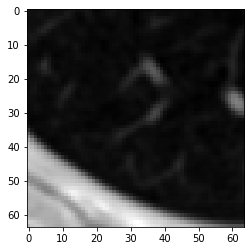

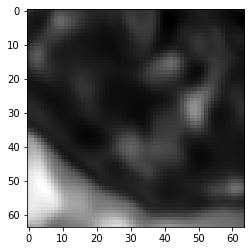

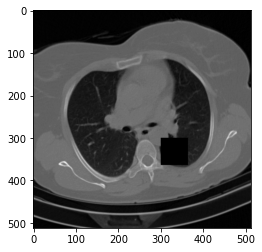

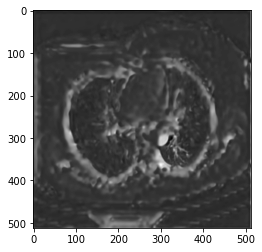

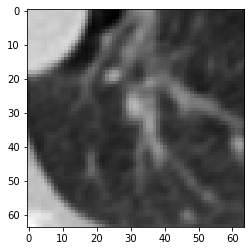

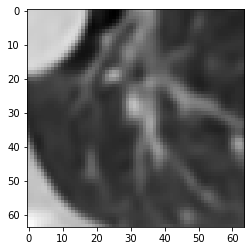

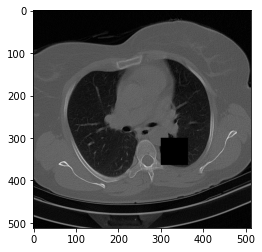

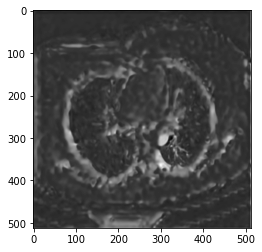

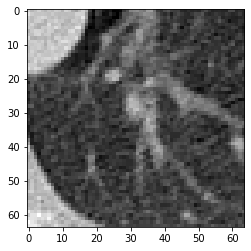

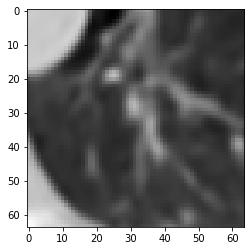

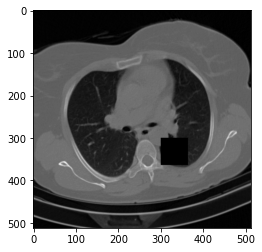

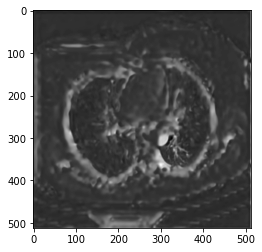

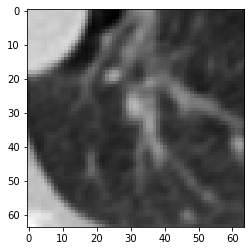

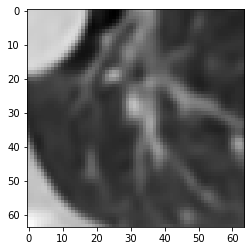

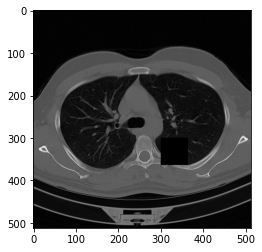

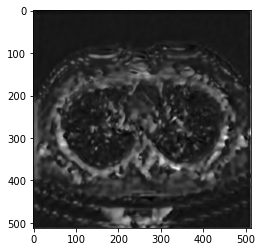

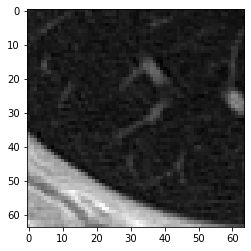

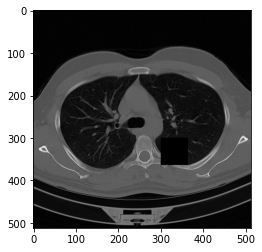

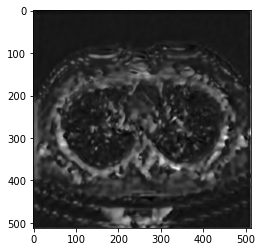

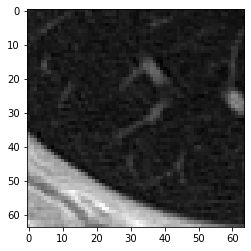

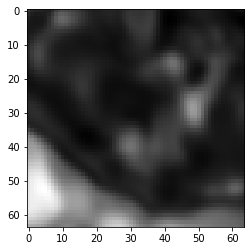

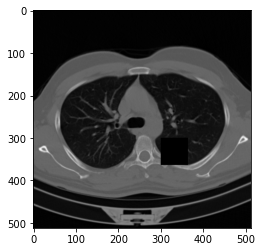

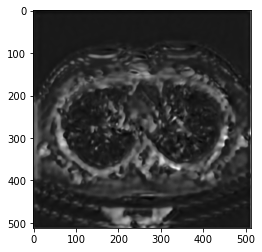

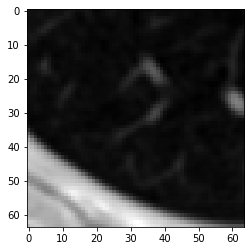

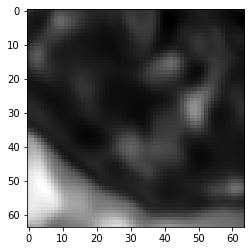

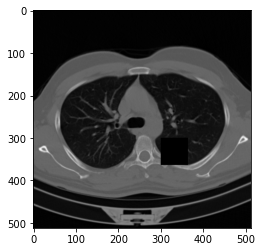

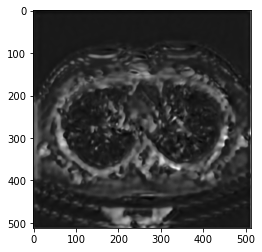

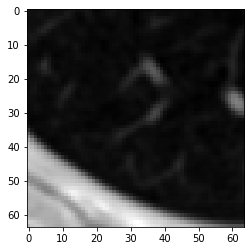

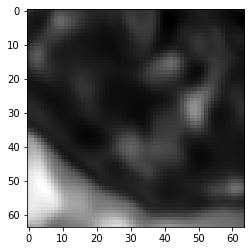

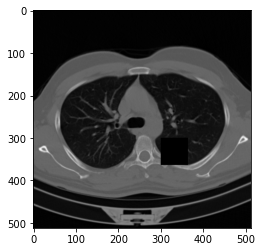

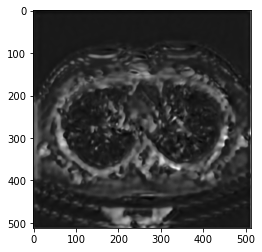

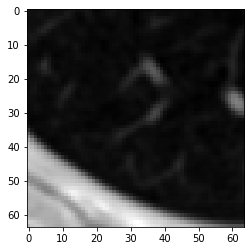

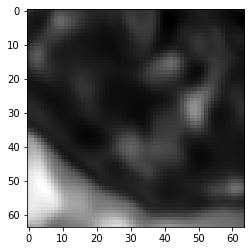

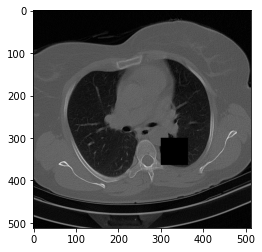

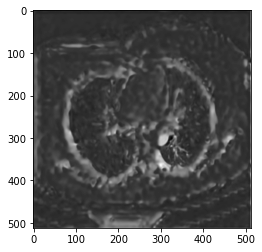

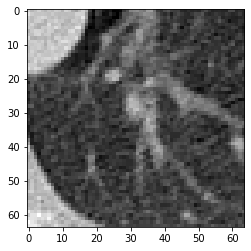

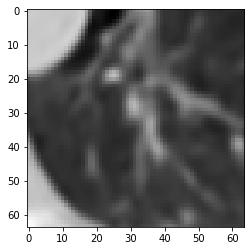

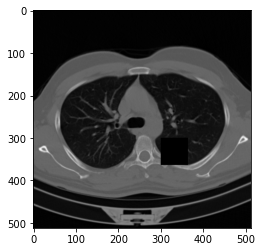

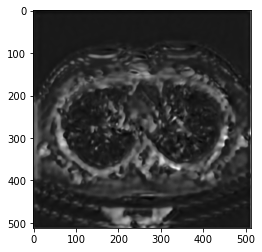

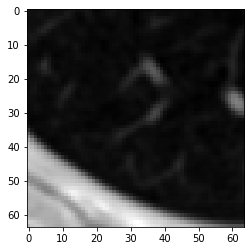

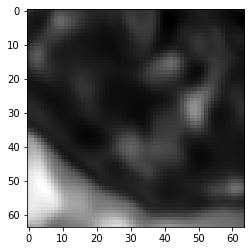

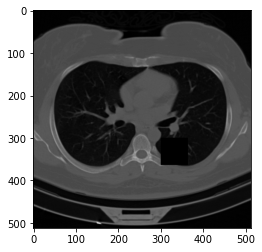

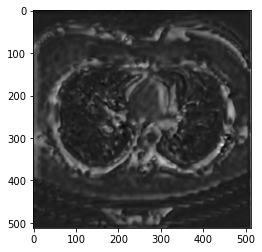

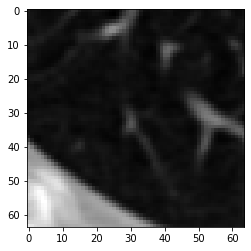

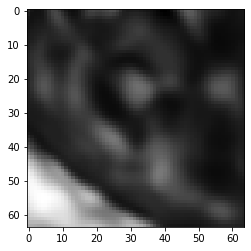

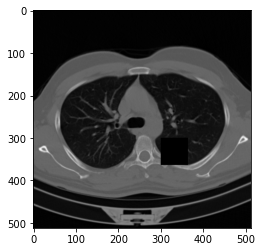

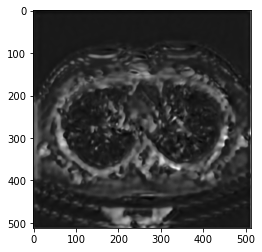

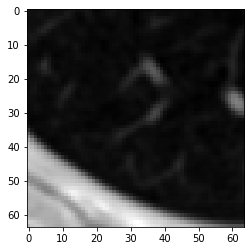

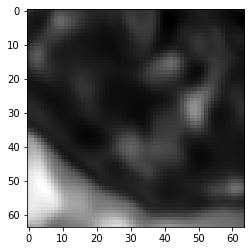

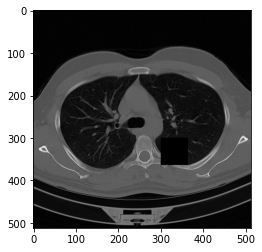

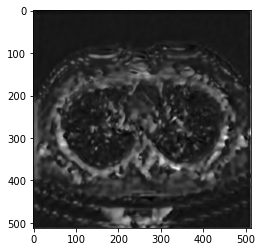

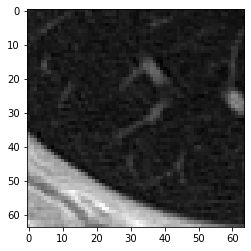

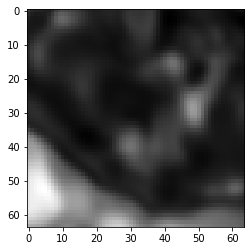

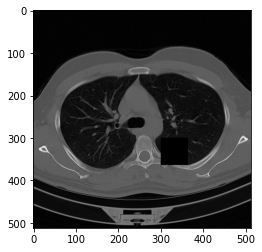

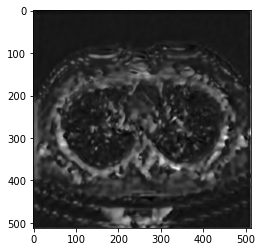

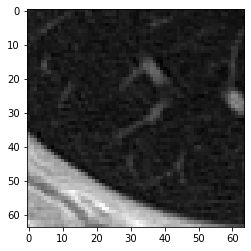

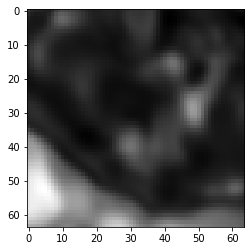

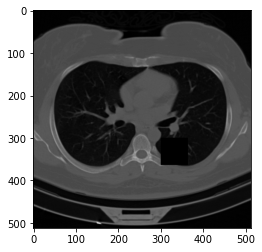

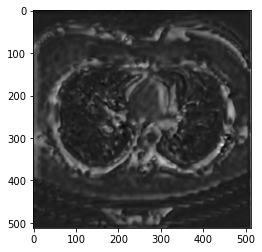

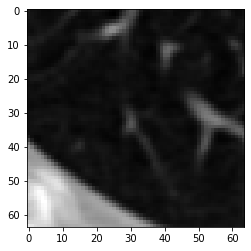

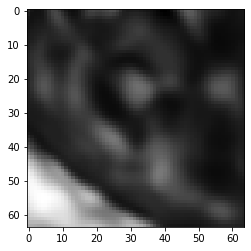

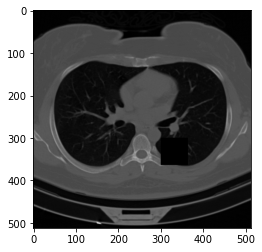

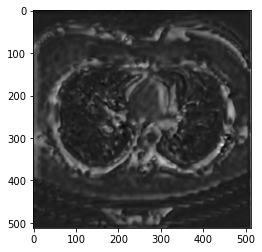

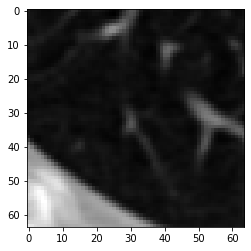

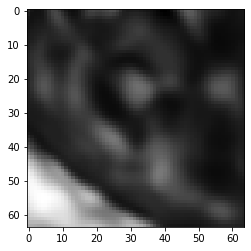

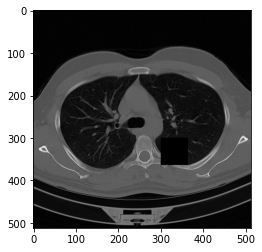

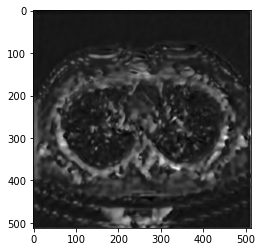

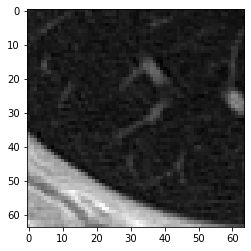

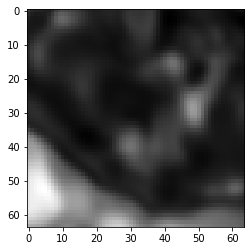

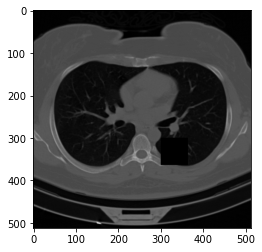

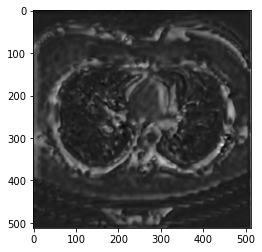

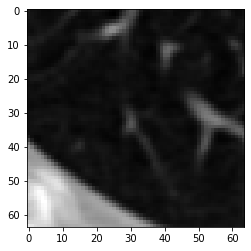

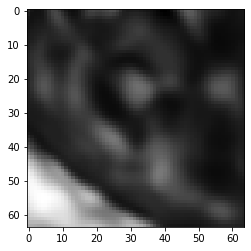

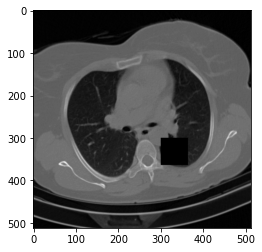

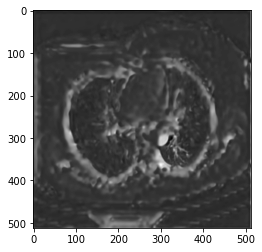

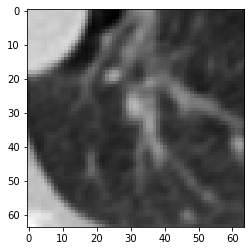

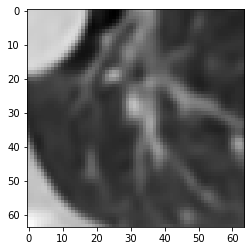

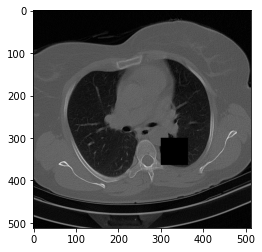

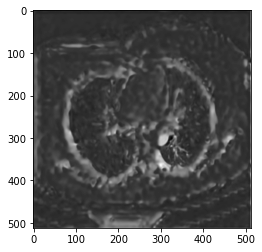

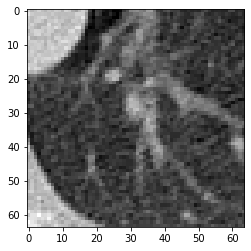

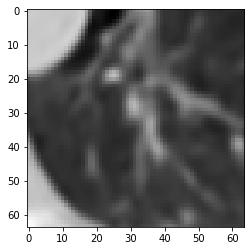

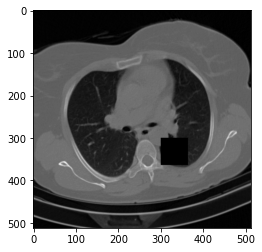

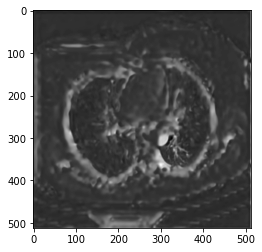

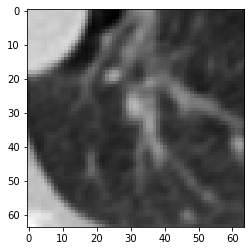

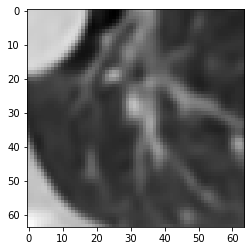

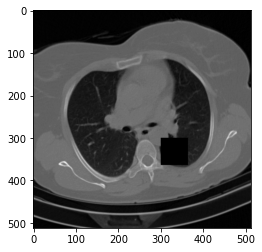

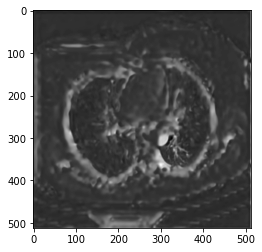

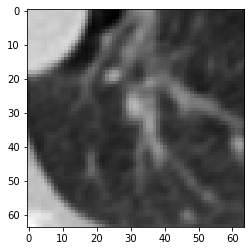

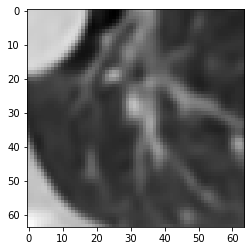

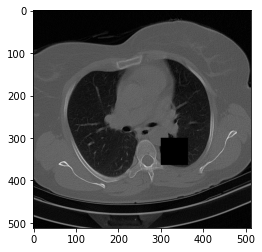

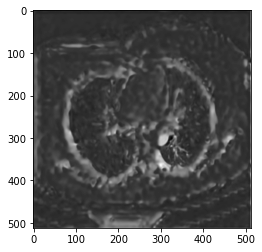

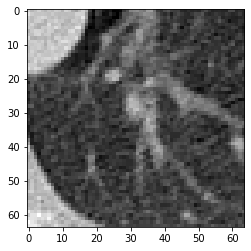

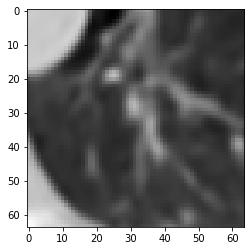

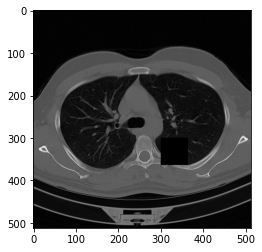

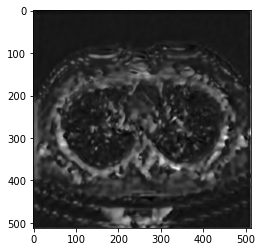

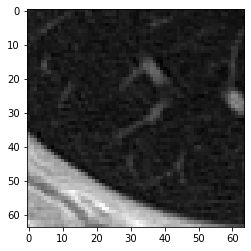

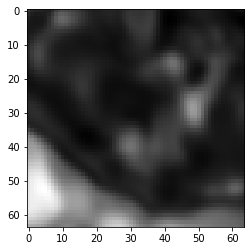

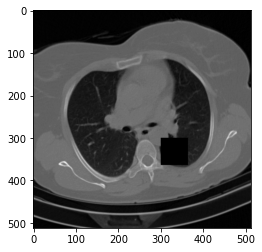

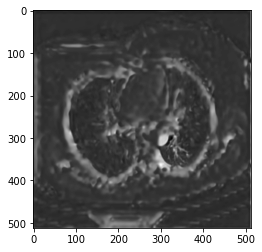

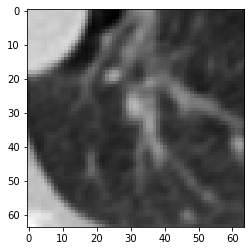

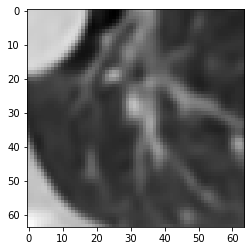

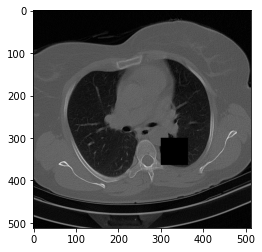

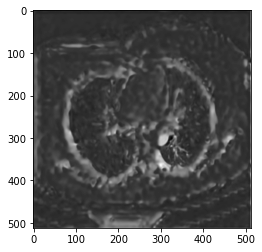

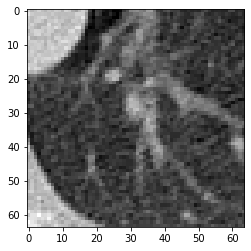

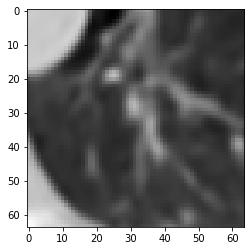

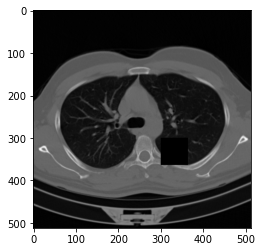

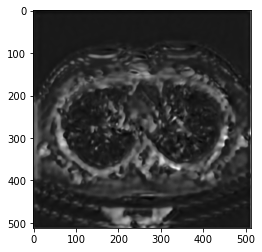

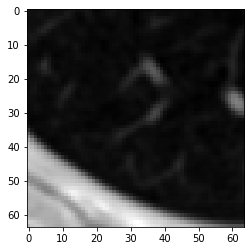

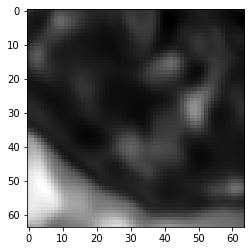

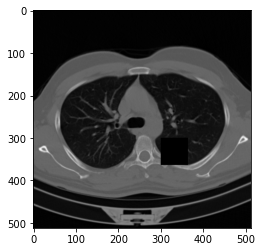

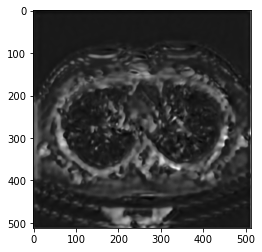

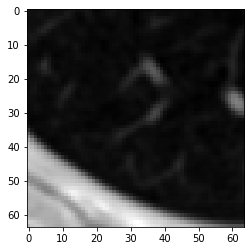

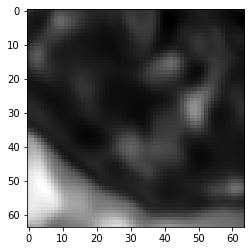

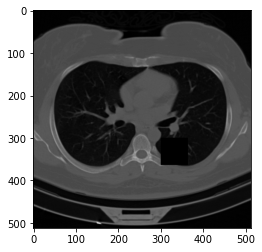

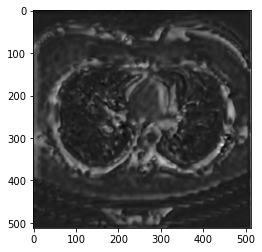

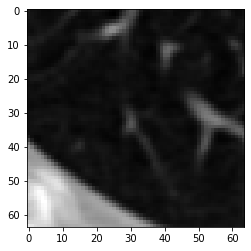

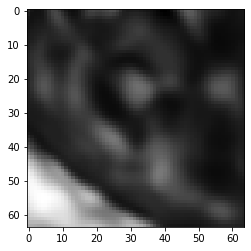

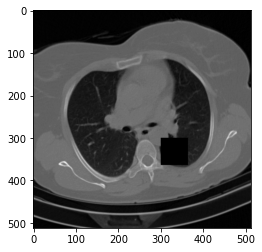

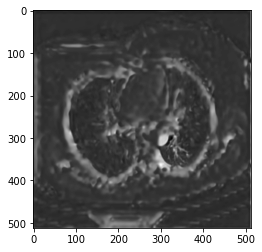

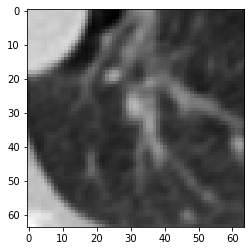

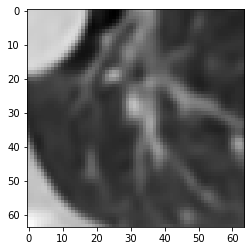

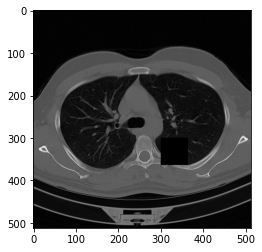

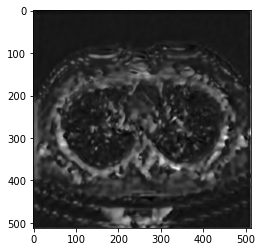

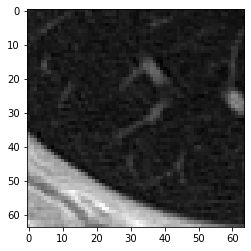

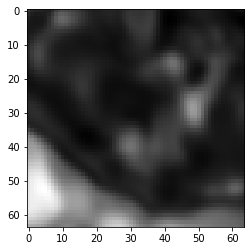

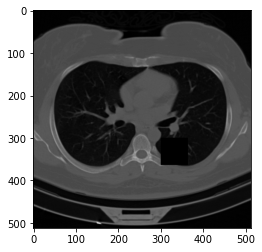

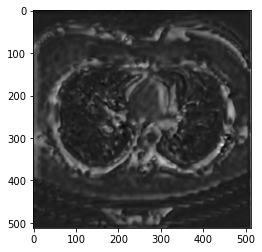

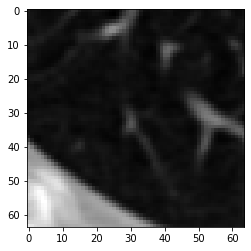

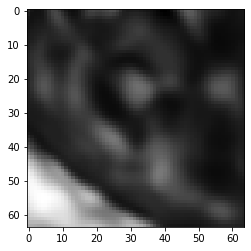

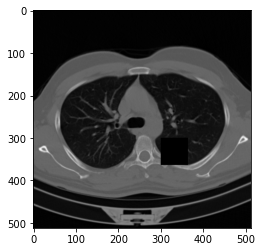

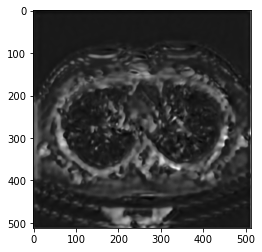

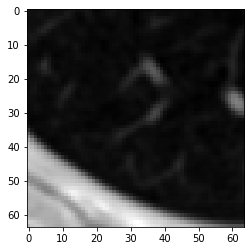

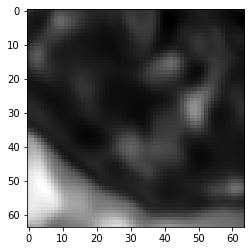

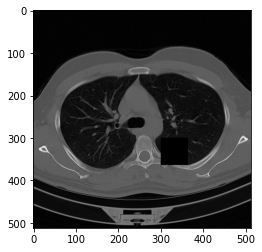

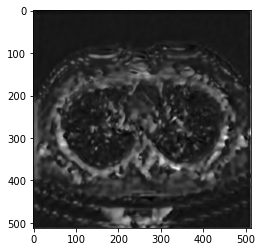

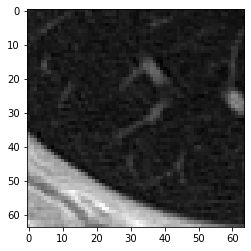

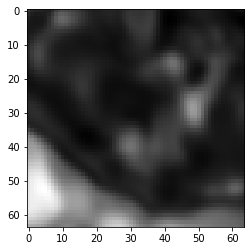

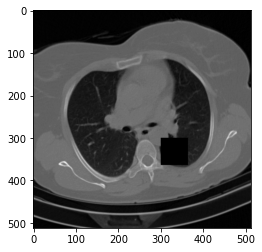

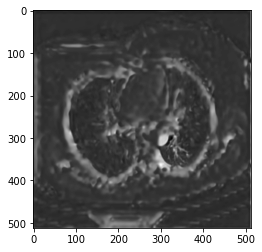

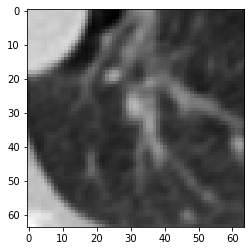

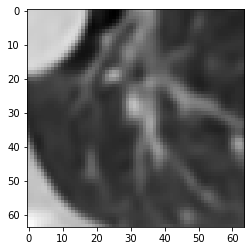

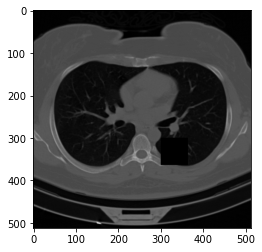

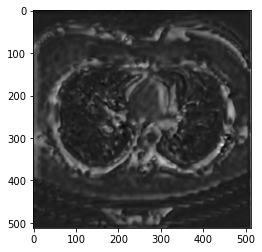

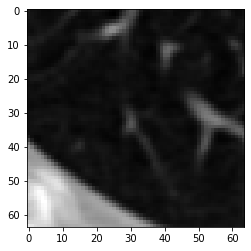

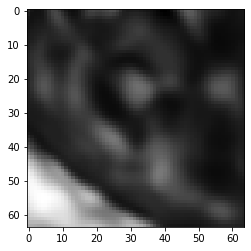

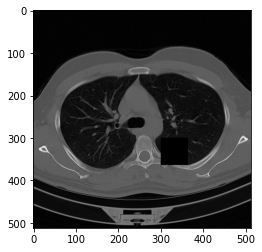

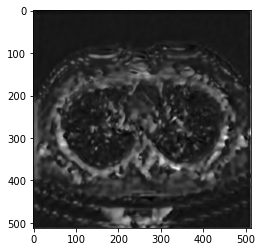

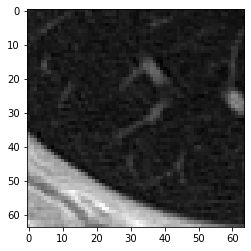

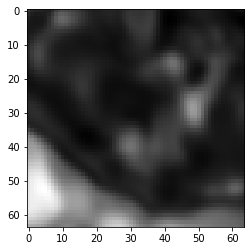

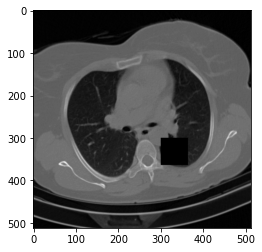

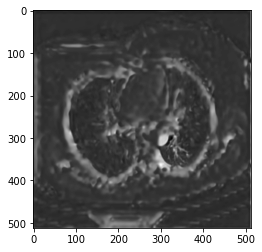

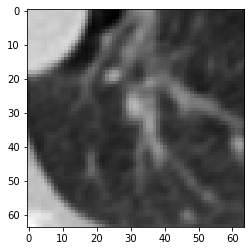

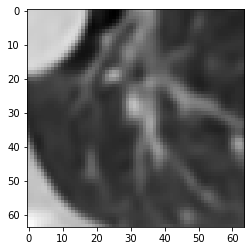

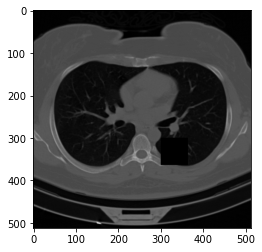

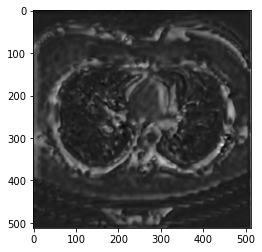

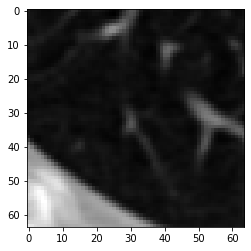

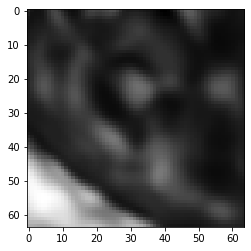

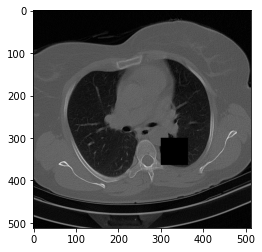

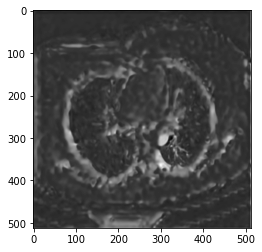

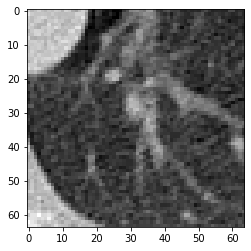

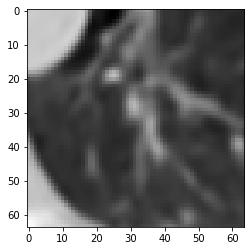

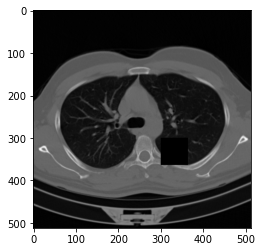

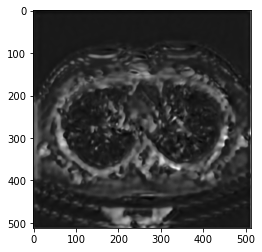

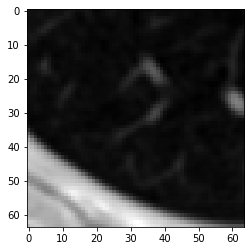

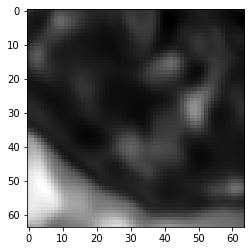

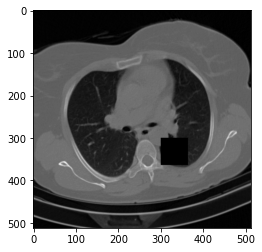

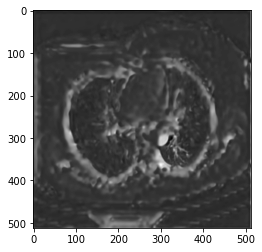

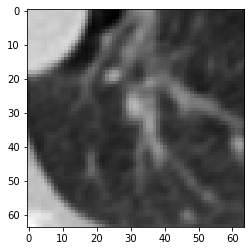

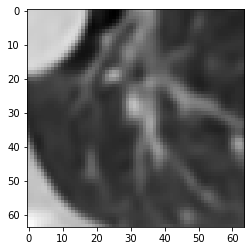

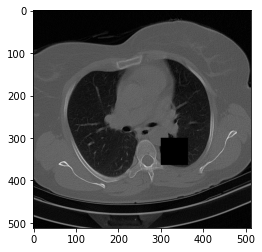

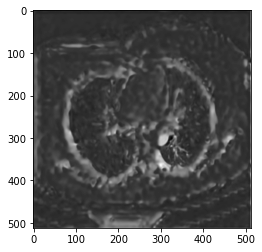

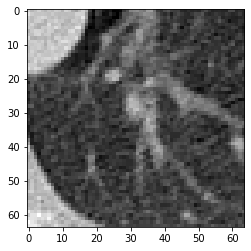

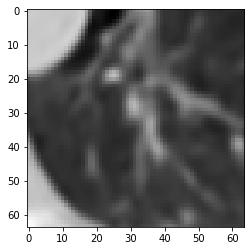

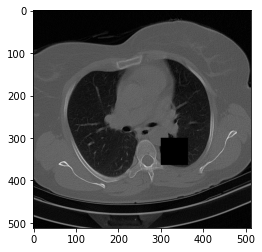

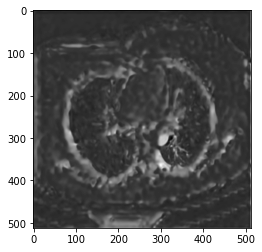

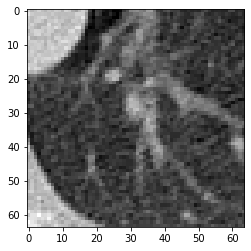

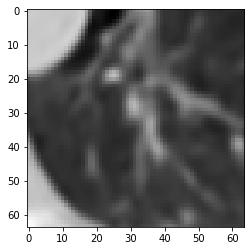

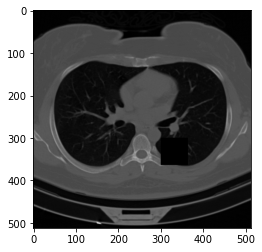

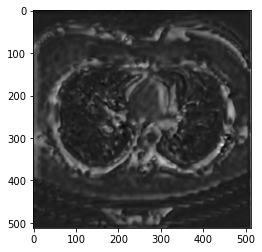

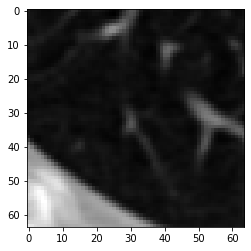

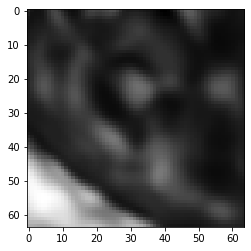

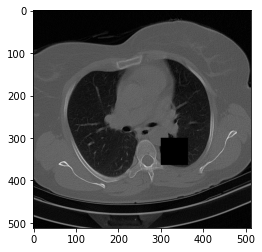

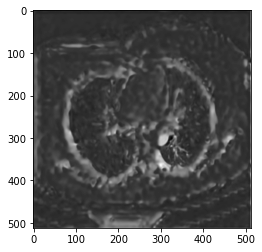

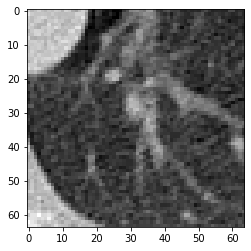

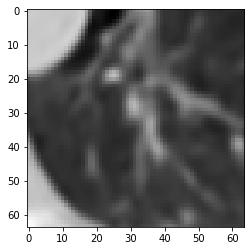

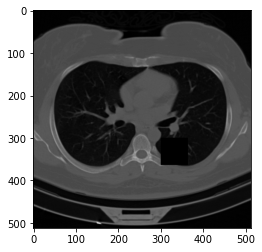

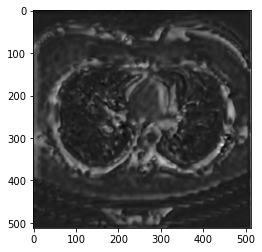

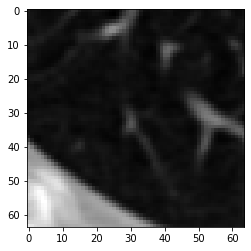

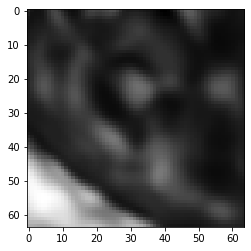

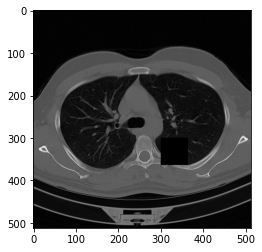

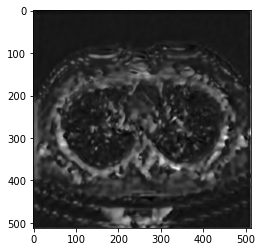

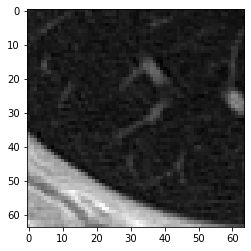

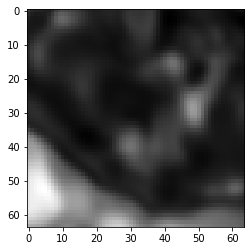

In [21]:
from ct_utils import ctshow

device = torch.device('cuda')
# Load data
DATASET_DIR = "COVID-CTset"
# train_set = CTDataset(DATASET_DIR, limit_dataset=1, num_masked_slices=2, padding_slices=3)
if EASY_MODE:
    mask_dims = (16, 16)
    inpaint_dims = (2, 16, 16)
else:
    mask_dims = (64, 64)
    inpaint_dims = (2, 64, 64)
    
train_set = CTDataset(DATASET_DIR, limit_dataset=5, num_masked_slices=2, padding_slices=3, mask_dims=mask_dims)

data_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=2)

# Initialize model
# model = VQVAE(in_channel=1).to(device)

with torch.no_grad():
    for i, (scan, mask, masked) in enumerate(data_loader):
        target = scan
        mask = mask.to(device)
        masked = masked.to(device)
        target = target.to(device)

        masked = masked[None, :]
        masked = masked.transpose(0, 1)
        output = model4(masked)
        output = output.squeeze()

        predicted_mask = torch.masked_select(output, mask)
        target_mask = torch.masked_select(target, mask)
        predicted_mask = predicted_mask.to(torch.device('cpu')).reshape(*inpaint_dims)
        target_mask = target_mask.to(torch.device('cpu')).reshape(*inpaint_dims)

        masked = masked.squeeze().cpu()
        ctshow(masked[3])
        ctshow(output[3].cpu())
        ctshow(target_mask[0])
        ctshow(predicted_mask[0])

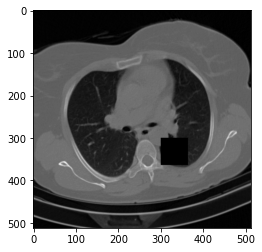

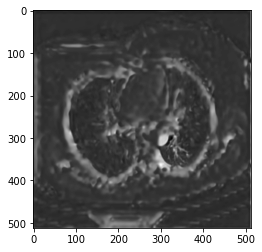

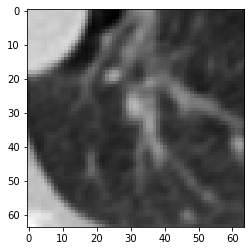

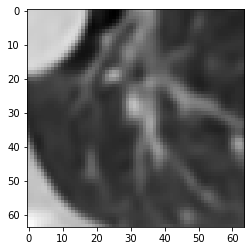

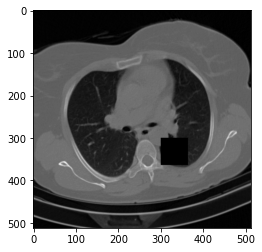

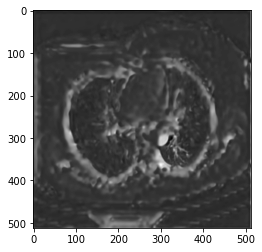

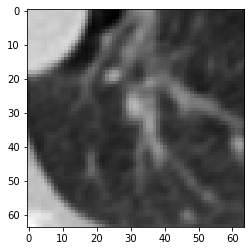

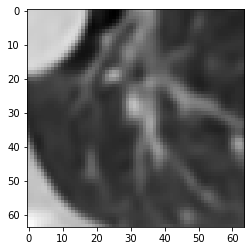

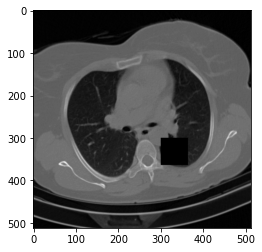

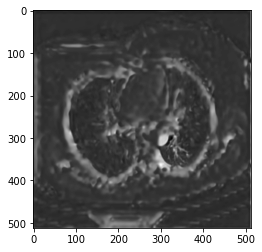

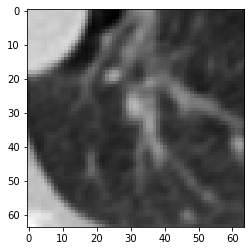

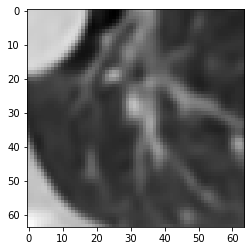

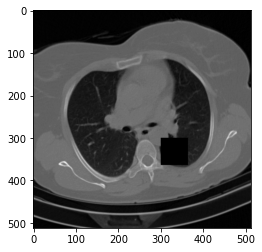

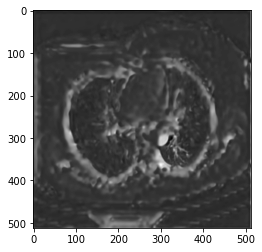

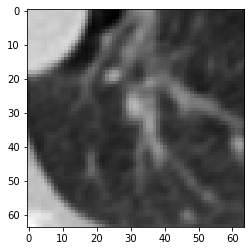

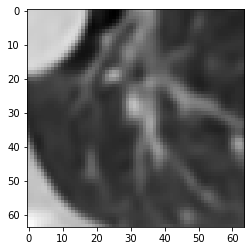

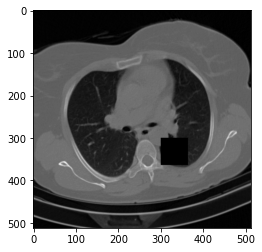

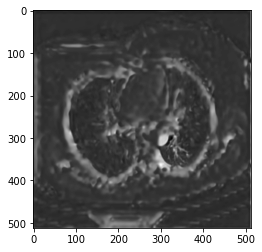

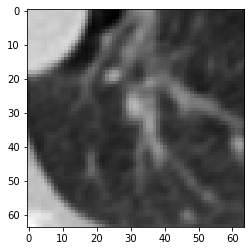

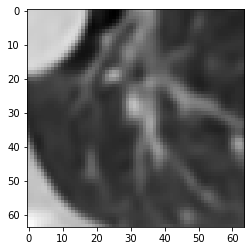

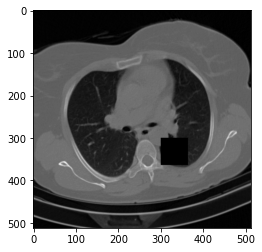

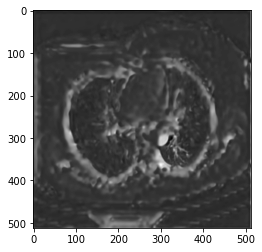

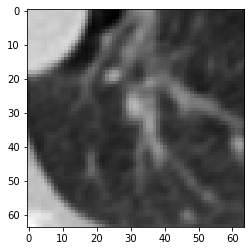

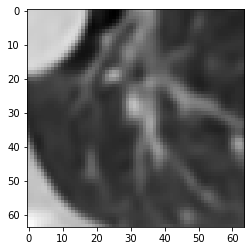

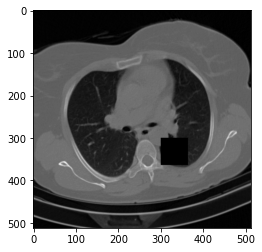

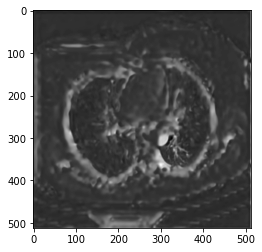

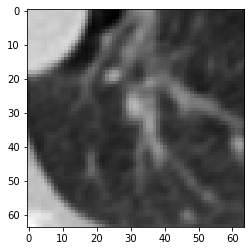

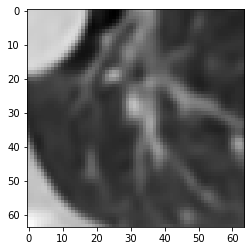

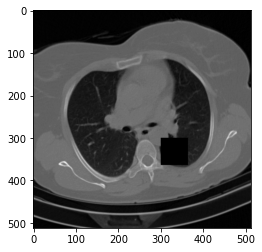

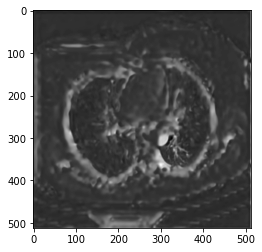

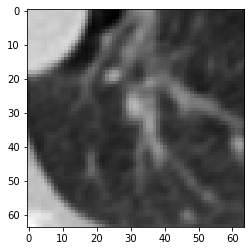

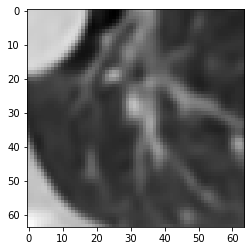

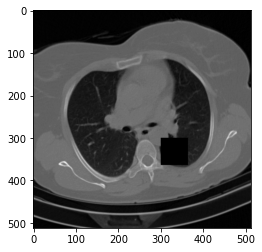

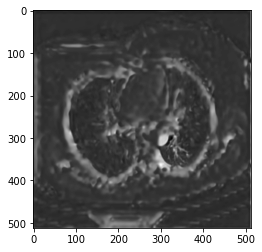

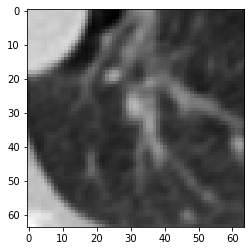

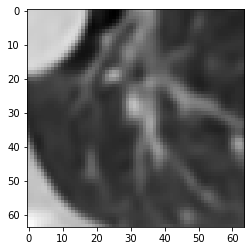

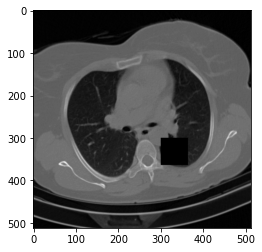

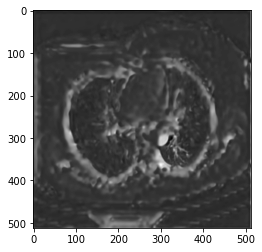

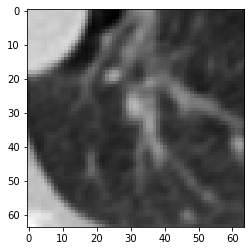

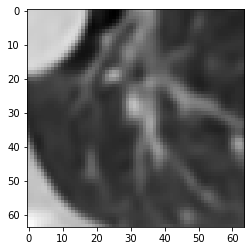

In [13]:
from ct_utils import ctshow

device = torch.device('cuda')
# Load data
DATASET_DIR = "COVID-CTset"
# train_set = CTDataset(DATASET_DIR, limit_dataset=1, num_masked_slices=2, padding_slices=3)
if EASY_MODE:
    mask_dims = (16, 16)
    inpaint_dims = (2, 16, 16)
else:
    mask_dims = (64, 64)
    inpaint_dims = (2, 64, 64)
    
train_set = CTDataset(DATASET_DIR, limit_dataset=1, num_masked_slices=2, padding_slices=3, mask_dims=mask_dims)

data_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=2)

# Initialize model
# model = VQVAE(in_channel=1).to(device)

with torch.no_grad():
    for i, (scan, mask, masked) in enumerate(data_loader):
        target = scan
        mask = mask.to(device)
        masked = masked.to(device)
        target = target.to(device)

        masked = masked[None, :]
        masked = masked.transpose(0, 1)
        output = model4(masked)
        output = output.squeeze()

        predicted_mask = torch.masked_select(output, mask)
        target_mask = torch.masked_select(target, mask)
        predicted_mask = predicted_mask.to(torch.device('cpu')).reshape(*inpaint_dims)
        target_mask = target_mask.to(torch.device('cpu')).reshape(*inpaint_dims)

        masked = masked.squeeze().cpu()
        ctshow(masked[3])
        ctshow(output[3].cpu())
        ctshow(target_mask[0])
        ctshow(predicted_mask[0])

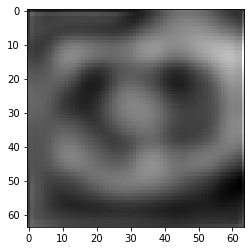

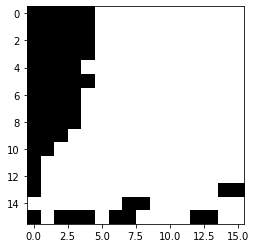

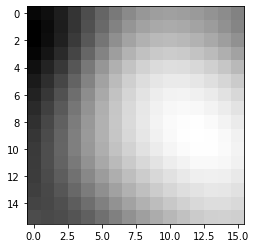

In [14]:
from ct_utils import ctshow

device = torch.device('cuda')
# Load data
DATASET_DIR = "COVID-CTset"
# train_set = CTDataset(DATASET_DIR, limit_dataset=1, num_masked_slices=2, padding_slices=3)
if EASY_MODE:
    mask_dims = (16, 16)
    inpaint_dims = (2, 16, 16)
else:
    mask_dims = (64, 64)
    inpaint_dims = (2, 64, 64)
    
train_set = CTDataset(DATASET_DIR, limit_dataset=1, num_masked_slices=2, padding_slices=3, mask_dims=mask_dims)

data_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=2)

# Initialize model
# model = VQVAE(in_channel=1).to(device)

with torch.no_grad():
    for i, (scan, mask, masked) in enumerate(data_loader):
        target = scan
        mask = mask.to(device)
        masked = masked.to(device)
        target = target.to(device)

        masked = masked[None, :]
        masked = masked.transpose(0, 1)
        output = model(masked)
        output = output.squeeze()

        predicted_mask = torch.masked_select(output, mask)
        target_mask = torch.masked_select(target, mask)
        predicted_mask = predicted_mask.to(torch.device('cpu')).reshape(*inpaint_dims)
        target_mask = target_mask.to(torch.device('cpu')).reshape(*inpaint_dims)

        masked = masked.squeeze().cpu()
        ctshow(masked[3])
        ctshow(output[3].cpu())
        ctshow(target_mask[0])
        ctshow(predicted_mask[0])
        
        




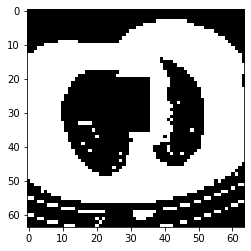

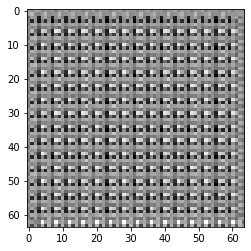

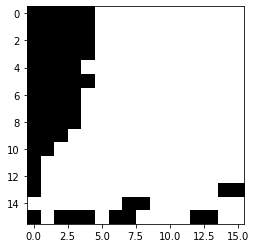

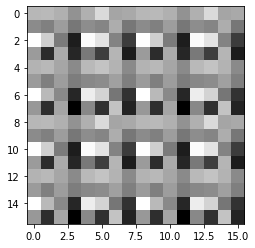

In [15]:
from ct_utils import ctshow

device = torch.device('cuda')
# Load data
DATASET_DIR = "COVID-CTset"
# train_set = CTDataset(DATASET_DIR, limit_dataset=1, num_masked_slices=2, padding_slices=3)
train_set = CTDataset(DATASET_DIR, limit_dataset=1, num_masked_slices=2, padding_slices=3, mask_dims=(16, 16))

data_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=2)

# Initialize model
# model = VQVAE(in_channel=1).to(device)

with torch.no_grad():
    for i, (scan, mask, masked) in enumerate(data_loader):
        target = scan
        mask = mask.to(device)
        masked = masked.to(device)
        target = target.to(device)

        masked = masked[None, :]
        masked = masked.transpose(0, 1)
        output, diff = model(masked)
        output = output.squeeze()

        predicted_mask = torch.masked_select(output, mask)
        target_mask = torch.masked_select(target, mask)
        predicted_mask = predicted_mask.to(torch.device('cpu')).reshape(2, 16, 16)
        target_mask = target_mask.to(torch.device('cpu')).reshape(2, 16, 16)

        masked = masked.squeeze().cpu()
        ctshow(masked[3])
        ctshow(output[3].cpu())
        ctshow(target_mask[0])
        ctshow(predicted_mask[0])
        
        




(array([8.863e+03, 4.717e+03, 9.330e+02, 5.109e+03, 1.162e+04, 1.094e+03,
        3.370e+02, 7.000e+01, 1.700e+01, 8.000e+00]),
 array([   0. ,  229.8,  459.6,  689.4,  919.2, 1149. , 1378.8, 1608.6,
        1838.4, 2068.2, 2298. ], dtype=float32),
 <BarContainer object of 10 artists>)

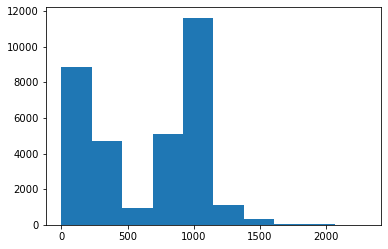

In [17]:
import matplotlib.pyplot as plt
plt.hist(masked.flatten())

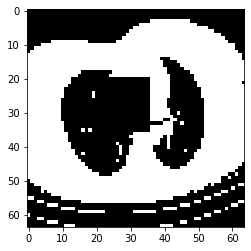

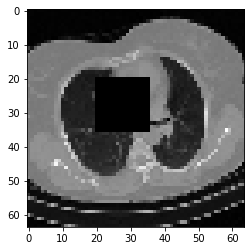

In [26]:
normalized_masked = torch.where(masked < 500, 0, 1)
ctshow(normalized_masked[4])
ctshow(masked[4])

(array([ 5688.,  2368.,  3349.,  1761.,   637.,   382.,   364.,   318.,
         1328., 16573.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.], dtype=float32),
 <BarContainer object of 10 artists>)

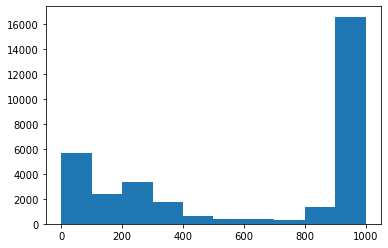

In [25]:
plt.hist(normalized_masked.flatten())